# Risk forecasting DNN model

In [1]:
# if running through colab, install yfinance
!pip3 install yfinance

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math

import yfinance as yf

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, SimpleRNN, GRU, Bidirectional
from tensorflow.keras.optimizers import Adam

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle

In [3]:
SERIES_PERIOD = 'max'
SERIES_INTERVAL = '1d'

LOOKBACK_WINDOW = 10
PREDICTION_LEN = 1
TRAIN_TEST_SPLIT = TRAIN_VAL_SPLIT = 0.9

EPOCHS = 25
BATCH_SIZE = 32

ACTIVE_LEARNING = False
AL_ITERATIONS = 50
AL_SAMPLE = 100
AL_EPOCHS = 1

### Dataset

In [4]:
# fetch closing values
sp500 = '^GSPC'

sp500_data = yf.Ticker(sp500)
sp500_history = sp500_data.history(period=SERIES_PERIOD, interval=SERIES_INTERVAL)
close = sp500_history.Close.loc[sp500_history.Close != 0][:-1]

# compute logarithmic returns
log_returns = np.log(close) - np.log(close.shift(1))
log_returns.dropna(inplace=True)

# compute numerical volitility as standard deviation over 5-point rolling window
volatility = close.pct_change().rolling(5).std()

# gather other variables
_open = sp500_history.Open[:-1]
_high = sp500_history.High[:-1]
_low = sp500_history.Low[:-1]
_volume = sp500_history.Volume[:-1]

# generate dataframe of closing prices and log returns
X = pd.DataFrame({
    'open': (_open - _open.min()) / _open.max(),
    'high': (_high - _high.min()) / _high.max(),
    'low': (_low - _low.min()) / _low.max(),
    'volume': (_volume - _volume.min()) / _volume.max(),

    'close': (close - close.min()) / close.max(),
    'returns': log_returns / log_returns.max(),  # already centred about 0
    'volatility': (volatility - volatility.min()) / volatility.max()
})

# remove NaN values and normalise
X.dropna(inplace=True)
X = X[list(X)].astype(np.float64)
X

,open,high,low,volume,close,returns,volatility
Date,,,,,,,
1950-01-10,0.003545,0.000077,0.000077,0.000129,0.000077,-0.026755,0.041578
1950-01-11,0.003557,0.000089,0.000090,0.000170,0.000090,0.032097,0.026233
1950-01-12,0.003488,0.000021,0.000021,0.000200,0.000021,-0.177951,0.085538
1950-01-13,0.003470,0.000002,0.000002,0.000231,0.000002,-0.049140,0.082654
1950-01-16,0.003480,0.000012,0.000013,0.000068,0.000013,0.027332,0.077147
...,...,...,...,...,...,...,...
2022-06-10,0.827221,0.821341,0.812441,0.343520,0.809789,-0.269617,0.141649
2022-06-13,0.798864,0.793067,0.777742,0.399096,0.778260,-0.360858,0.159306
2022-06-14,0.783331,0.780622,0.771755,0.360129,0.775310,-0.034505,0.118952


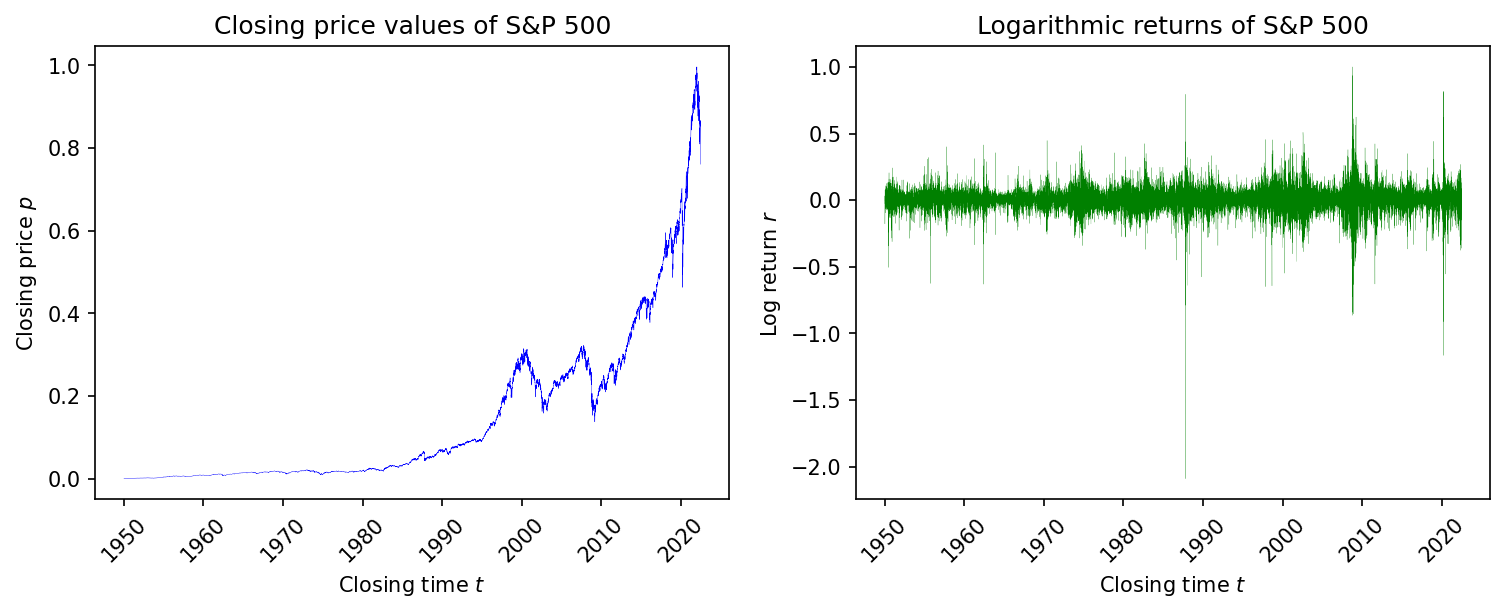

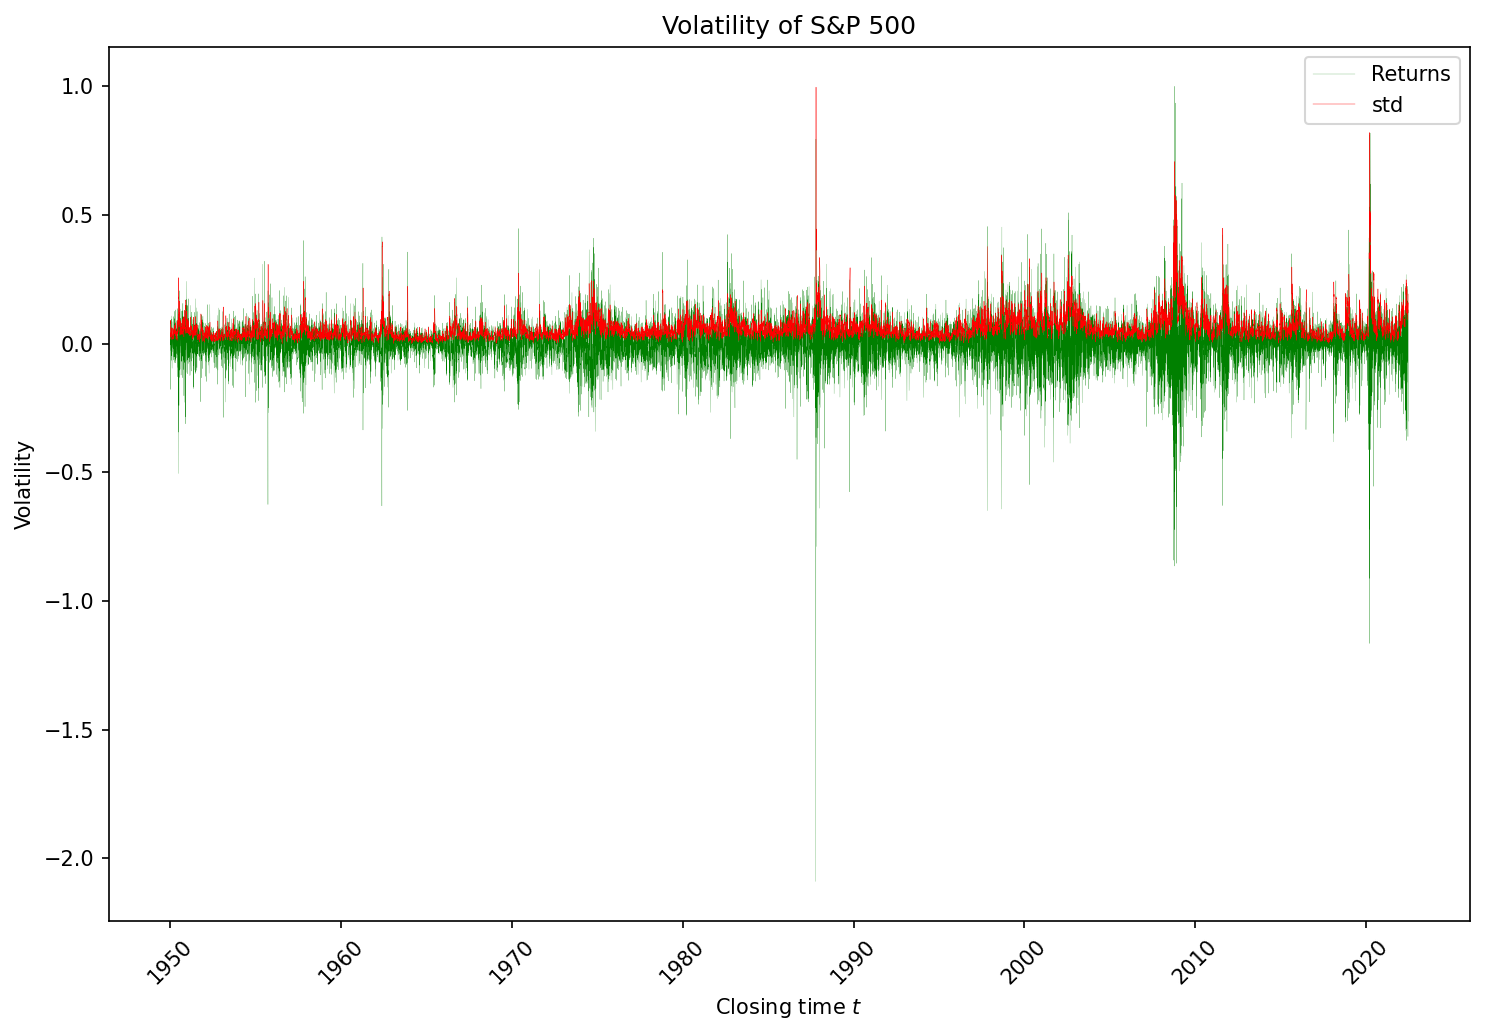

In [5]:
fig, ax = plt.subplots(1, 2, figsize=(12, 4), dpi=150)

ax[0].plot(X.close, linewidth=0.2, color='b')
ax[0].set(title=f'Closing price values of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Closing price $p$')
ax[0].tick_params(axis='x', rotation=45)

ax[1].plot(X.returns, linewidth=0.1, color='g')
ax[1].set(title=f'Logarithmic returns of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Log return $r$')
ax[1].tick_params(axis='x', rotation=45)

fig, ax = plt.subplots(figsize=(10, 7), dpi=150)
ax.plot(X.returns, linewidth=0.1, color='g', label='Returns')
ax.plot(X.volatility, linewidth=0.2, color='r', label='std')
ax.set(title=f'Volatility of S&P 500', xlabel=r'Closing time $t$', ylabel=r'Volatility')
ax.tick_params(axis='x', rotation=45)
ax.legend()

plt.tight_layout()
plt.show()

In [6]:
# build dataset:
#   each instance consists of a `LOOKBACK_WINDOW` length time series (prev `LOOKBACK_WINDOW`) over variables
#   each label is the volatility value that comes at the next timestep after this series
X_data, y_data = [], []

for i in range(X.shape[0] - LOOKBACK_WINDOW - PREDICTION_LEN):
    X_data.append(X.values[i: i + LOOKBACK_WINDOW])
    y_data.append(X.volatility[i + LOOKBACK_WINDOW: i + LOOKBACK_WINDOW + PREDICTION_LEN])

# convert X, y to numpy arrays
X_data = np.array(X_data)
y_data = np.array(y_data)

# split into training and testing data
# X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=(1 - TRAIN_TEST_SPLIT), shuffle=True)
split = math.floor(X_data.shape[0] * TRAIN_TEST_SPLIT)

X_train = X_data[:split]
y_train = y_data[:split]
X_test = X_data[split:]
y_test = y_data[split:]

X_train, y_train = shuffle(X_train, y_train)

print(f"{TRAIN_TEST_SPLIT * 100:.0f}% training data, {(1 - TRAIN_TEST_SPLIT) * 100:.0f}% testing data")
print("Train:", X_train.shape, y_train.shape, '\nTest: ', X_test.shape, y_test.shape)

90% training data, 10% testing data
Train: (16395, 10, 7) (16395, 1) 
Test:  (1822, 10, 7) (1822, 1)


In [7]:
# build RNN comprising of one LSTM layer and one FCN layer
rnn_model = Sequential([
    SimpleRNN(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    SimpleRNN(256, activation='tanh'),
    Dense(1, activation='linear')
])

gru_model = Sequential([
    GRU(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    GRU(256, activation='tanh'),
    Dense(1, activation='linear')
])

lstm_model = Sequential([
    LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:])),
    LSTM(256, activation='tanh'),
    Dense(1, activation='linear')
])

bidir_model = Sequential([
    Bidirectional(
        LSTM(256, return_sequences=True, activation='tanh', input_shape=(X_train.shape[1:]))
    ),
    Bidirectional(
        LSTM(256, activation='tanh')
    ),
    Dense(1, activation='linear')
])

models = {
    'LSTM': lstm_model
}

adam_opt = Adam(learning_rate=0.001, decay=1e-5)

for model in models.values():
    model.compile(loss='mae', optimizer=adam_opt, metrics=['mse'])

In [8]:
# GSx sampling for initial seed pool
def initial_selection(X, y, k=AL_SAMPLE):
    # select first sample as closest to centroid of all training samples
    centroid = np.mean(X, axis=0)

    # compute euclidean distance
    distances = np.max(np.linalg.norm(X - centroid, axis=2), axis=1)

    # select instances with smallest distance
    train_indices = np.argpartition(distances, k)[:k]
    X_instances = X[train_indices]
    y_instances = y[train_indices]

    # gather remaining instances
    val_indices = np.setdiff1d(range(X.shape[0]), train_indices)
    X_instances_val = X[val_indices]
    y_instances_val = y[val_indices]

    return X_instances, y_instances, X_instances_val, y_instances_val


# GSy sampling for selecting instances to add to training pool
def select_instances(model, X_t, y_t, X_v, y_v, k=AL_SAMPLE):
    # generate outputs y over validation set
    y_pred = model.predict(X_v)
    
    # for each prediction, find the minimum distance to an output in the training set
    _y_pred = y_pred.squeeze(1)
    _y_t = y_t.squeeze(1)
    distances = np.min(np.abs(_y_pred[:, np.newaxis] - _y_t), axis=1)

    # select new training instances as those furthest from training set outputs
    train_indices = np.argpartition(distances, -k)[-k:]
    val_indices = np.setdiff1d(range(X_v.shape[0]), train_indices)

    X_t = np.append(X_t, X_v[train_indices], axis=0)
    y_t = np.append(y_t, y_v[train_indices], axis=0)
    X_v = X_v[val_indices]
    y_v = y_v[val_indices]

    return X_t, y_t, X_v, y_v

In [9]:
# train each model
histories = {}
for m in range(len(models)):
    model = list(models.values())[m]
    model_name = list(models.keys())[m]

    # active learning training
    if ACTIVE_LEARNING:
        print("Active Learning Method...")
        # initial training over seed dataset
        X_pool, y_pool, X_val, y_val = initial_selection(X_train, y_train)
        history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT, verbose=False)

        # store metrics
        histories.update({
            model_name: {
                'loss': [np.min(history.history['loss'])],
                'mse': [np.min(history.history['mse'])],
                'val_loss': [np.min(history.history['val_loss'])],
                'val_mse': [np.min(history.history['val_mse'])]
            }
        })

        # iteratively train model
        for it in range(AL_ITERATIONS):
            print(f"Iteration {it}; pool = {X_pool.shape[0]}, val = {X_val.shape[0]}")
            if X_val.shape[0] >= AL_SAMPLE:
                # use GSy method to select samples to add to the training pool
                X_pool, y_pool, X_val, y_val = select_instances(lstm_model, X_pool, y_pool, X_val, y_val)

                # train model over pool
                history = lstm_model.fit(X_pool, y_pool, epochs=AL_EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
                
                # store metrics
                histories[model_name]['loss'].append(np.min(history.history['loss']))
                histories[model_name]['mse'].append(np.min(history.history['mse']))
                histories[model_name]['val_loss'].append(np.min(history.history['val_loss']))
                histories[model_name]['val_mse'].append(np.min(history.history['val_mse']))
            else:
                break
    # baseline training process
    else:
        print("Basic Training Method...")
        history = model.fit(X_train, y_train, epochs=EPOCHS, batch_size=BATCH_SIZE, validation_split=TRAIN_VAL_SPLIT)
        histories.update({
            model_name: history.history
        })

Basic Training Method...
Epoch 1/25
52/52 [==============================] - 6s 45ms/step - loss: 0.0243 - mse: 0.0013 - val_loss: 0.0225 - val_mse: 0.0011
Epoch 2/25
52/52 [==============================] - 2s 31ms/step - loss: 0.0216 - mse: 9.3865e-04 - val_loss: 0.0188 - val_mse: 8.6742e-04
Epoch 3/25
52/52 [==============================] - 2s 31ms/step - loss: 0.0181 - mse: 6.6612e-04 - val_loss: 0.0175 - val_mse: 8.0376e-04
Epoch 4/25
52/52 [==============================] - 2s 31ms/step - loss: 0.0165 - mse: 5.4543e-04 - val_loss: 0.0181 - val_mse: 6.5670e-04
Epoch 5/25
52/52 [==============================] - 3s 56ms/step - loss: 0.0141 - mse: 4.3689e-04 - val_loss: 0.0131 - val_mse: 4.5685e-04
Epoch 6/25
52/52 [==============================] - 3s 56ms/step - loss: 0.0128 - mse: 3.8023e-04 - val_loss: 0.0125 - val_mse: 4.3651e-04
Epoch 7/25
52/52 [==============================] - 2s 31ms/step - loss: 0.0132 - mse: 3.9954e-04 - val_loss: 0.0124 - val_mse: 4.4616e-04
Epoch 8/25

In [10]:
predictions = {}
metrics = {}
for m in range(len(models.values())):
    model = list(models.values())[m]
    model_name = list(models.keys())[m]
    prediction = model.predict(X_test)
    
    mae = np.abs(np.subtract(y_test, prediction)).mean()
    mse = np.square(np.subtract(y_test, prediction)).mean()
    mape = np.abs((y_test - prediction) / y_test).mean() * 100

    _msle = pd.DataFrame(np.subtract(np.log(y_test + 1), np.log(prediction + 1)))
    _msle.dropna(inplace=True)
    msle = float(np.square(_msle).mean())

    metrics.update({
        model_name: {
            'mae': mae,
            'mse': mse,
            'msle': msle,
            'mape': mape
        }
    })

    predictions.update({    
        model_name: prediction * volatility.max() + volatility.min()
    })

    print(f" - {model_name}: \n\t mae = {mae:.5f}; mse = {mse:.5f}; msle = {msle:.5f}; mape = {mape:.5f}%")

 - LSTM: 
	 mae = 0.01728; mse = 0.00069; msle = 0.00052; mape = 27.99251%


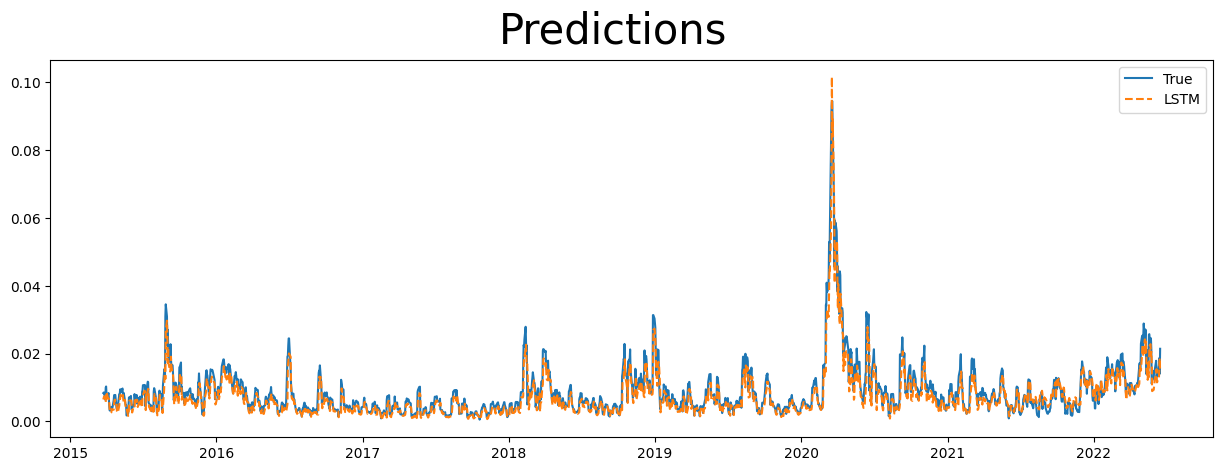

In [11]:
y_test_unscaled = y_test * volatility.max() + volatility.min()
y_test_plot = pd.Series(y_test_unscaled.squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

fig, ax = plt.subplots(len(metrics), 1, figsize=(15, 5 * len(metrics)), dpi=100)
fig.suptitle("Predictions", fontsize=30)

if len(metrics) > 1:
    for m in range(len(metrics)):
        model = list(models.keys())[m]
        model_name = list(metrics.keys())[m]
        y_pred_plot = pd.Series(predictions[model_name].squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

        ax[m].plot(y_test_plot, label='True')
        ax[m].plot(y_pred_plot, linestyle='--', label=model_name)
        ax[m].legend(loc=0)
        
elif len(metrics) == 1:
        model = list(models.keys())[0]
        model_name = list(metrics.keys())[0]
        y_pred_plot = pd.Series(predictions[model_name].squeeze(1), index=X.volatility[split + LOOKBACK_WINDOW + 1:].keys())

        ax.plot(y_test_plot, label='True')
        ax.plot(y_pred_plot, linestyle='--', label=model_name)
        ax.legend(loc=0)

plt.show()

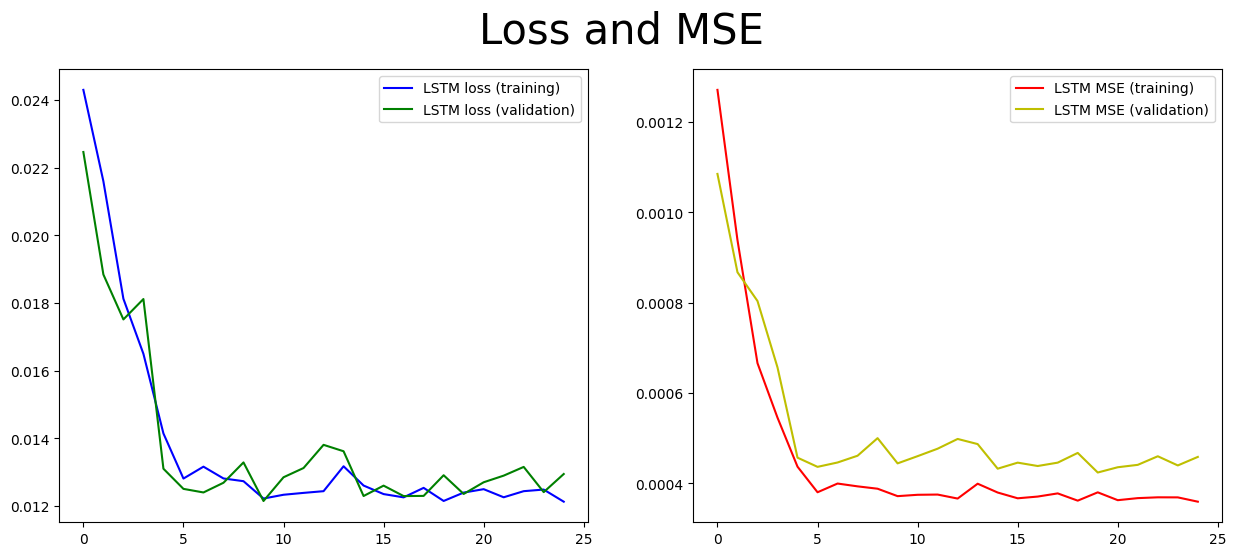

In [12]:
fig, ax = plt.subplots(len(metrics), 2, figsize=(15, 6 * len(metrics)), dpi=100)
fig.suptitle("Loss and MSE", fontsize=30)

if len(metrics) > 1:
    for m in range(len(metrics)):
        model = list(models.keys())[m]

        ax[m, 0].plot(histories[model]['loss'], color='b', label=f"{model} loss (training)")
        ax[m, 0].plot(histories[model]['val_loss'], color='g', label=f"{model} loss (validation)")
        ax[m, 0].legend(loc=0)

        ax[m, 1].plot(histories[model]['mse'], color='r', label=f"{model} MSE (training)")
        ax[m, 1].plot(histories[model]['val_mse'], color='y', label=f"{model} MSE (validation)")
        ax[m, 1].legend(loc=0)
elif len(metrics) == 1:
    model = list(models.keys())[0]

    ax[0].plot(histories[model]['loss'], color='b', label=f"{model} loss (training)")
    ax[0].plot(histories[model]['val_loss'], color='g', label=f"{model} loss (validation)")
    ax[0].legend(loc=0)

    ax[1].plot(histories[model]['mse'], color='r', label=f"{model} MSE (training)")
    ax[1].plot(histories[model]['val_mse'], color='y', label=f"{model} MSE (validation)")
    ax[1].legend(loc=0)

**Basic training:**

*Run 1:*
- mae = 0.01317; 
- mse = 0.00049; 
- msle = 0.00038; 
- mape = 26.38048%

*Run 2:*
- mae = 0.01490
- mse = 0.00056
- msle = 0.00042
- mape = 30.15045%

**Active learning:**

*Run 1:*
- mae = 0.01370
- mse = 0.00056
- msle = 0.00042
- mape = 27.88457%

*Run 2:*
- mae = 0.01782
- mse = 0.00098
- msle = 0.00065
- mape = 31.75339%
